# Subspace learning experiments

Test recurrent gain control against Oja's rule for principal subspace learning.

In [1]:
import os
import multiprocessing
from pathlib import Path
from typing import Optional
print(f'cpus: {multiprocessing.cpu_count()}')

# set to OMP_NUM_THREADS=1 to avoid multithreading conflicts
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy as sp
import seaborn as sns
from tqdm import tqdm

import frame_whitening as fw
import frame_whitening.data as fwd

cpus: 128


[Text(0.5, 1.0, 'cov')]

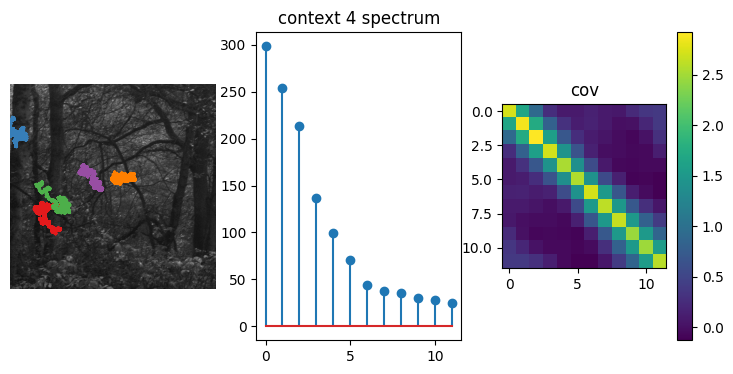

In [14]:
data_dir = "/mnt/home/tyerxa/ceph/datasets/datasets/vanhateren_imc"
files = sorted(os.listdir(data_dir))
seed = 420
rng = np.random.default_rng(seed)

n_images = 10
images = fwd.load_images(n_images=n_images, crop_size=512, rng=rng)

images = [img / np.max(img) for img in images]

img = images[5]

patch_h, patch_w = 1, 12
img_h, img_w = img.shape

sigma = .2
n_steps = 40_000

fig, ax = plt.subplots(1, 3, figsize=(9, 4))
im = ax[0].imshow(img, cmap="gray")

n_contexts = 5
cols = sns.color_palette("Set1", n_contexts)

rng = np.random.default_rng(6969)
all_contexts, walk_coords = fwd.get_contexts(img, patch_h, patch_w, n_contexts, sigma, n_steps, pad_factor=1., rng=rng)
for idx, walk_hw in enumerate(walk_coords):
    walk_h, walk_w = walk_hw[:, 0], walk_hw[:, 1]
    ax[0].plot(walk_h, walk_w, color=cols[idx])

ax[0].axis("off")

ctx = 4
X = all_contexts[ctx]
X0 = X.reshape(-1, patch_w)
X0 = X0 - np.mean(X0, axis=0)


_, S, Vh = np.linalg.svd(X0, compute_uv=True, full_matrices=False)
# fig, ax = plt.subplots(1, 1)
ax[1].stem(S**2)

Css = np.cov(X0.T)
im = ax[2].imshow(Css*1000)
plt.colorbar(im)
ax[1].set(title=f'context {ctx} spectrum' )
ax[2].set(title=f'cov' )

In [ ]:


def get_conv_frame(n: int, m: int, h: int, w: int) -> npt.NDArray[np.float64]:
    """Returns a specific convolutional frame that connects all pairs within a window.

    Assumes the nxm image is vectorized, and the filter/neighbourhood size is hxw.

    Parameters
    ----------
    n: Height of image.
    m: Width of image.
    h: Height of convolutional filter.
    w: Width of convolutional filter.

    Returns
    -------
    W: Convolutional frame.
    """
    assert n >= 1 and m >= 1
    assert n >= h and m >= w


    nm = n * m
    # hw = h * w
    
    # singly-connected interneurons
    WI = np.eye(nm)
    
    # doubly-connected (paired) interneurons
    idx_set = set()
    WP = []
    normalize = lambda x: x / np.linalg.norm(x)

    all_indices = list(itertools.product(range(n), range(m)))
    for i, j in all_indices:
        for k, l in all_indices:

            # get flat indices
            ij_flat = np.ravel_multi_index((i, j), (n, m))
            kl_flat = np.ravel_multi_index((k, l), (n, m))
            if (
                (i, j) != (k, l) and
                (ij_flat, kl_flat) not in idx_set and
                (kl_flat, ij_flat) not in idx_set and
                np.abs(i - k) < h and
                np.abs(j - l) < w
            ):
                idx_set.add((ij_flat, kl_flat))
                # pair (i, j) and (k, l) via flattened indices, and normalize
                wp = np.zeros(nm)
                wp[ij_flat] = 1
                wp[kl_flat] = 1
                WP.append(normalize(wp))

    WP = np.stack(WP, 0)
    
    W = np.concatenate([WI, WP], 0).T
    return W


[Text(0.5, 1.0, 'cov')]

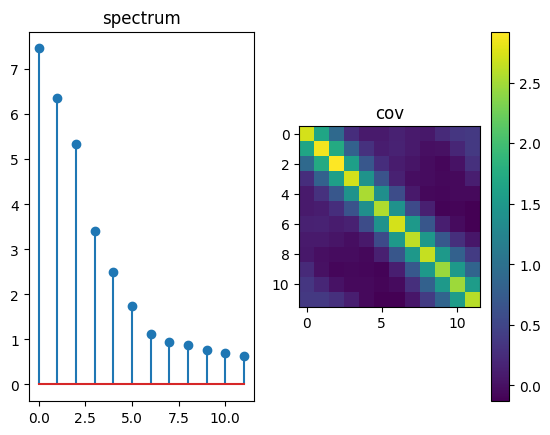

In [12]:
Css = np.array([[ 2.72503556e-03,  1.66159109e-03,  9.09272723e-04,
         2.66247738e-04,  9.31352443e-05,  8.43885225e-05,
         1.45249217e-04,  8.68591686e-05,  7.03666403e-05,
         2.36188196e-04,  3.54822018e-04,  3.80442455e-04],
       [ 1.66159109e-03,  2.86647170e-03,  1.73230638e-03,
         8.22416147e-04,  3.04907668e-04,  1.17087328e-04,
         1.65404890e-04,  8.69869962e-05, -1.04023498e-05,
         4.06856537e-06,  2.02270055e-04,  3.71472451e-04],
       [ 9.09272723e-04,  1.73230638e-03,  2.92233438e-03,
         1.59358444e-03,  6.98926401e-04,  2.67397956e-04,
         1.05786740e-04,  4.15509392e-05, -2.52410062e-05,
        -7.80714568e-05,  1.86188029e-05,  2.94864577e-04],
       [ 2.66247738e-04,  8.22416147e-04,  1.59358444e-03,
         2.71091487e-03,  1.43292864e-03,  6.53174004e-04,
         1.45567135e-04, -2.24374888e-05, -2.89584743e-05,
        -6.36836427e-05, -5.02806319e-05,  1.22041099e-04],
       [ 9.31352443e-05,  3.04907668e-04,  6.98926401e-04,
         1.43292864e-03,  2.53818099e-03,  1.39415755e-03,
         5.76428701e-04,  8.09043519e-05, -6.48001179e-05,
        -7.36216171e-05, -4.74706064e-05, -5.90117140e-05],
       [ 8.43885225e-05,  1.17087328e-04,  2.67397956e-04,
         6.53174004e-04,  1.39415755e-03,  2.56166077e-03,
         1.42768852e-03,  5.49699590e-04,  1.41706942e-04,
        -9.98097377e-05, -9.28916753e-05, -1.30619483e-04],
       [ 1.45249217e-04,  1.65404890e-04,  1.05786740e-04,
         1.45567135e-04,  5.76428701e-04,  1.42768852e-03,
         2.72958966e-03,  1.51385198e-03,  6.82686722e-04,
         1.20612918e-04, -3.78548836e-05, -1.27079765e-04],
       [ 8.68591686e-05,  8.69869962e-05,  4.15509392e-05,
        -2.24374888e-05,  8.09043519e-05,  5.49699590e-04,
         1.51385198e-03,  2.61636919e-03,  1.49368019e-03,
         7.08752187e-04,  2.79948961e-04,  4.95579453e-05],
       [ 7.03666403e-05, -1.04023498e-05, -2.52410062e-05,
        -2.89584743e-05, -6.48001179e-05,  1.41706942e-04,
         6.82686722e-04,  1.49368019e-03,  2.64888457e-03,
         1.50652638e-03,  8.14155040e-04,  4.02700589e-04],
       [ 2.36188196e-04,  4.06856537e-06, -7.80714568e-05,
        -6.36836427e-05, -7.36216171e-05, -9.98097377e-05,
         1.20612918e-04,  7.08752187e-04,  1.50652638e-03,
         2.46573628e-03,  1.50893197e-03,  8.56130707e-04],
       [ 3.54822018e-04,  2.02270055e-04,  1.86188029e-05,
        -5.02806319e-05, -4.74706064e-05, -9.28916753e-05,
        -3.78548836e-05,  2.79948961e-04,  8.14155040e-04,
         1.50893197e-03,  2.47427529e-03,  1.56061374e-03],
       [ 3.80442455e-04,  3.71472451e-04,  2.94864577e-04,
         1.22041099e-04, -5.90117140e-05, -1.30619483e-04,
        -1.27079765e-04,  4.95579453e-05,  4.02700589e-04,
         8.56130707e-04,  1.56061374e-03,  2.59721762e-03]])

fig, ax = plt.subplots(1, 2)
Css = Css * 1000
ax[0].stem(np.linalg.svd(Css)[1])
im = ax[1].imshow(Css)
plt.colorbar(im)
ax[0].set(title=f'spectrum' )
ax[1].set(title=f'cov' )

In [6]:
def compute_subspace_error(V: npt.NDArray[np.float64], V0: npt.NDArray[np.float64]) -> float:
    return np.mean(sp.linalg.subspace_angles(V, V0))

def subspace_learning(
    x_dim: int, 
    s_dim: int, 
    step_oja: float, 
    relative_speed: float, 
    iters: int = 100_000,
    method: str = 'direct',
    seed: Optional[int] = None,
    X0=None,
    neighborhood_size: int = 1,
    frame_type: str = 'full',
    ) -> npt.NDArray[np.float64]:
    assert method in ['direct', 'weights', 'gain_ctrl']
    assert frame_type in ['full', 'conv']

    rng = np.random.default_rng(seed)
    step_size = relative_speed * step_oja

    # ground truth principal subspace
    _, s_dim = X0.shape
    Css = np.cov(X0.T) * 1000
    Lss = np.linalg.cholesky(Css)

    _, _, Vh = np.linalg.svd(Css, full_matrices=False, compute_uv=True)
    V0 = Vh.T
    V0 = V0[:, :x_dim]  # top x_dim eigenvectors

    # init weights from s to x
    V = rng.standard_normal((x_dim, s_dim))

    # init M
    Q = sp.stats.ortho_group.rvs(x_dim, random_state=rng)
    P = sp.stats.ortho_group.rvs(x_dim+1, random_state=rng)[:,:x_dim]
    W0 = Q@np.diag(rng.uniform(1, 1.5, (x_dim,)))**2 @P.T
    M = W0@W0.T

    if frame_type == 'full':
        KN = x_dim * (x_dim + 1) // 2
        W = rng.standard_normal((x_dim, KN))
    else:
        W = fw.get_conv_frame(x_dim, 1, neighborhood_size, 1)
    K = W.shape[1]
    W = fw.normalize_frame(W)

    err = []
    In = np.eye(x_dim)
    g = np.ones(K)

    for _ in range(iters):
        err.append(compute_subspace_error(V.T, V0))

        s = rng.standard_normal(s_dim) @ Lss.T

        if method == 'direct':
            M_inv = np.linalg.inv(M)
            y = M_inv @ V @ s
            M += step_size * (np.outer(y, y) - In)

        elif method == 'gain_ctrl':
            WGW = W @ (g[:, None] * W.T)  # equiv to W@diag(g)@W.T
            M_inv = np.linalg.inv(In + WGW)

            y = M_inv @ V @ s
            z = W.T @ y
            g += step_size * (z**2 - 1)

        else: #if method == 'weights':
            M_inv = np.linalg.inv(W0 @ W0.T)
            y = M_inv@V@s
            W0 += step_size*(np.outer(y, y) @ W0 - W0)

        V += step_oja * (np.outer(y, s) - np.diag(y * y) @ V)

    return err

def simulate_many(
    step_oja: float,
    relative_speed: float,
    n_repeats: int, 
    method: str,
    neighborhood_size: int = 5,
    frame_type: str = 'full',
) -> npt.NDArray[np.float64]:
    """Run all simulations in parallel."""
    s_dim = 12
    x_dim = 3

    iters = int(1E5)

    with multiprocessing.Pool() as pool:
        all_errors = []
        pbar = tqdm(total=n_repeats)
        for errors in pool.starmap(
            subspace_learning, 
            [(x_dim, s_dim, step_oja, relative_speed, iters, method, i, X0, neighborhood_size, frame_type) for i in range(n_repeats)]):
            all_errors.append(errors)
            pbar.update(1)
    all_errors = np.array(all_errors)
    return all_errors

n_repeats = 10

# all_errors_m = simulate_many(10., n_repeats, 'direct')

relative_speed = 50.
step_oja_g = 1E-4
neighborhood_size = 4
all_errors_g_full = simulate_many(
    step_oja_g,
    relative_speed, 
    n_repeats, 
    'gain_ctrl', 
    neighborhood_size, 
    frame_type='full'
    )

neighborhood_size = 2
all_errors_g_conv = simulate_many(
    step_oja_g,
    relative_speed, 
    n_repeats, 
    'gain_ctrl', 
    neighborhood_size, 
    frame_type='conv'
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.37s/it]


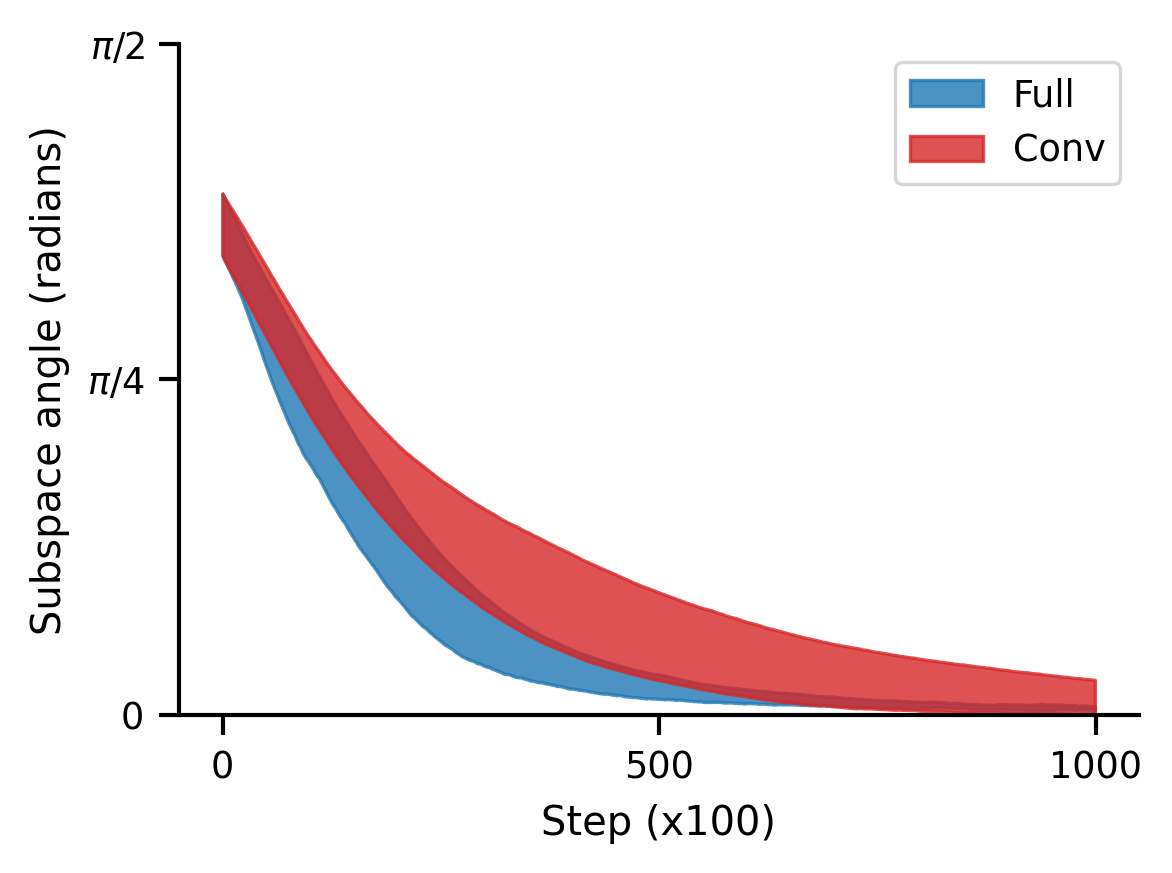

In [7]:
def plot_shaded_error(all_errors, ax, **kwargs):
    mu = np.mean(all_errors, axis=0)
    sigma = np.std(all_errors, axis=0)#np.sqrt(all_errors.shape[0])
    x = np.arange(len(mu))
    ax.fill_between(x, mu+sigma, np.clip(mu-sigma, 0, None), alpha=.8, **kwargs)


with sns.plotting_context('paper'):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey='all', sharex='all', dpi=300)
    # plot_shaded_error(all_errors_m, ax, label='Direct')
    # ax.plot(all_errors_g10.T)

    step_skip = 100

    plot_shaded_error(all_errors_g_full[:, ::step_skip], ax, label='Full', color='C0')
    plot_shaded_error(all_errors_g_conv[:, ::step_skip], ax, label='Conv', color='C3')
    ax.set(
        # title=r'$\eta=$'f'{relative_speed}''$\zeta$',
        ylabel='Subspace angle (radians)', 
        xlabel='Step (x100)', 
        xticks = (0, 500, 1000),
        ylim=(0, np.pi/2), 
        yticks=[0, np.pi/4, np.pi/2], 
        yticklabels=[0, r'$\pi/4$', r'$\pi/2$']
        )
    ax.legend()
    sns.despine()
    fig.tight_layout()